In [1]:
import pandas as pd

df_ver = pd.read_csv("verification/031-01.tsv", sep="\t")
df_enr = pd.read_csv("enrollment/031-g-01.tsv", sep="\t")

print("Verification columns:", df_ver.columns.tolist())
print("Enrollment columns:", df_enr.columns.tolist())
print("First few rows (verification):\n", df_ver.head())
print("First few rows (enrollment):\n", df_enr.head())


Verification columns: ['0.0000', '51.6500', '49.6100', '212.000000', '1.000000', '151.000000', '64.000000']
Enrollment columns: ['0.0000', '18.2500', '86.5400', '54.000000', '1.000000', '114.000000', '62.000000']
First few rows (verification):
    0.0000  51.6500  49.6100  212.000000  1.000000  151.000000  64.000000
0    0.01    51.44    50.49       247.0       0.0       151.0       64.0
1    0.02    51.30    50.82       274.0       0.0       153.0       63.0
2    0.03    51.23    51.00       292.0       0.0       153.0       63.0
3    0.04    51.23    51.09       320.0       0.0       153.0       63.0
4    0.05    51.23    51.09       337.0       0.0       155.0       63.0
First few rows (enrollment):
    0.0000  18.2500  86.5400  54.000000  1.000000  114.000000  62.000000
0    0.01    18.25    86.54      249.0       0.0       114.0       62.0
1    0.02    18.25    86.54      362.0       0.0       114.0       62.0
2    0.03    18.25    86.54      519.0       0.0       115.0       63.0

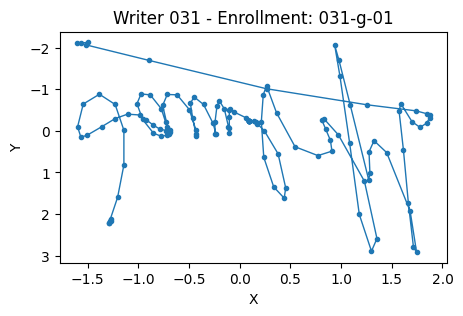

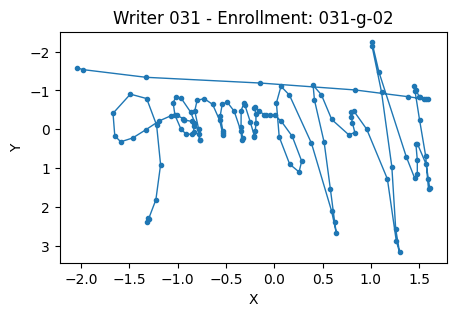

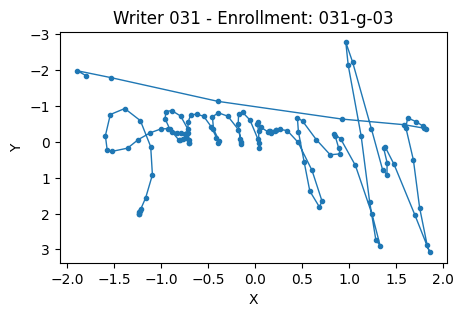

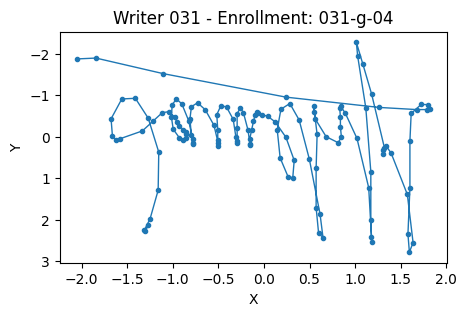

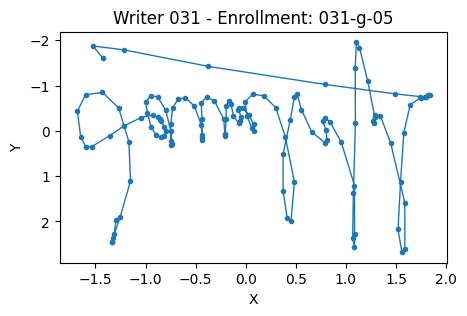

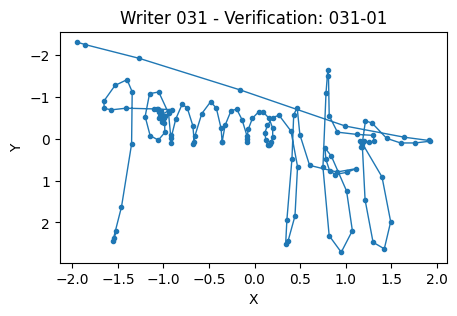

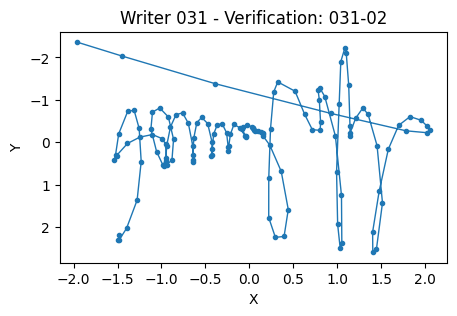

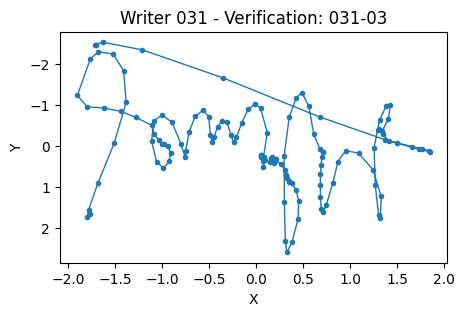

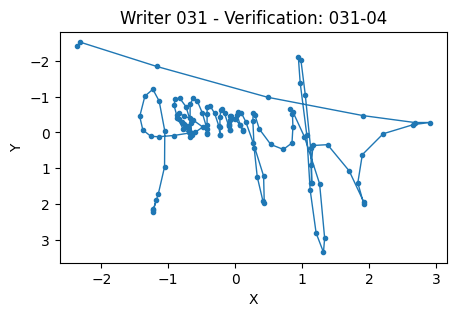

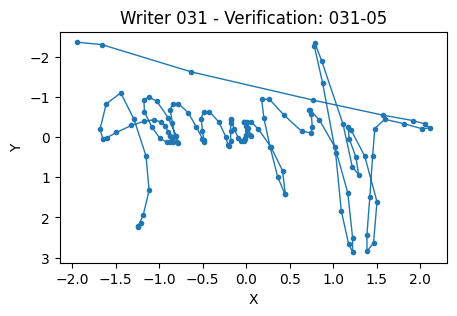

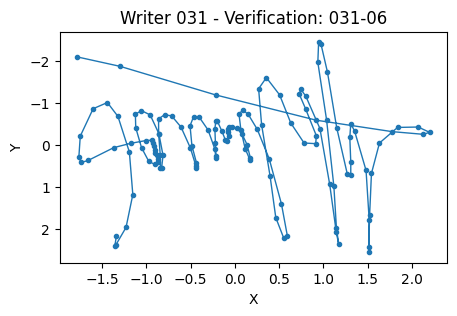

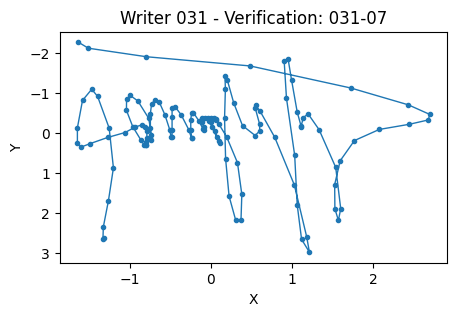

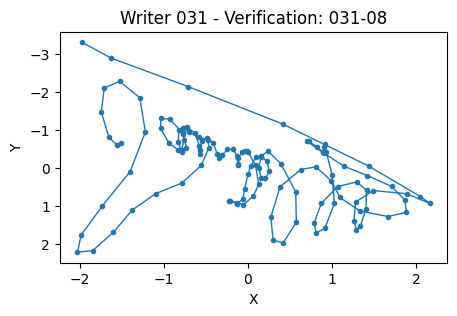

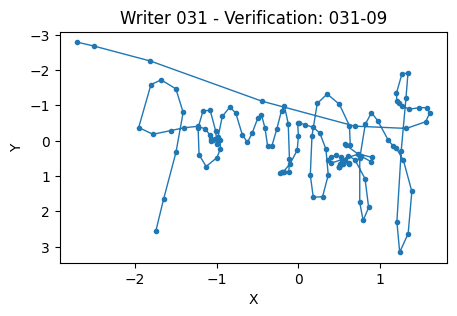

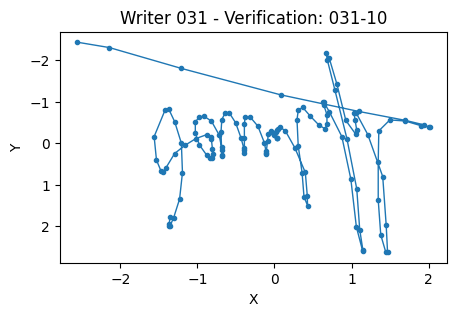

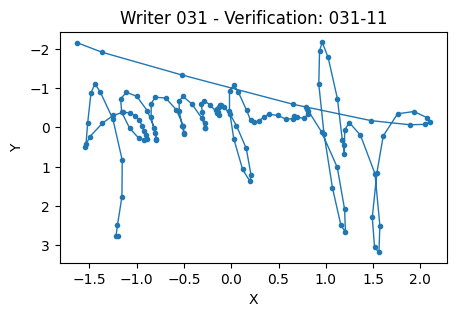

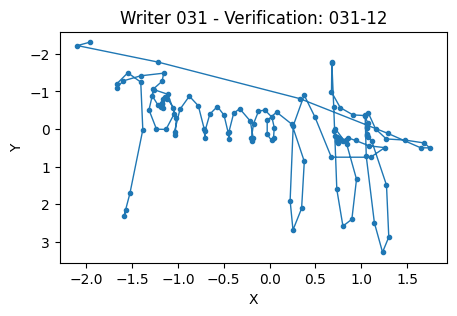

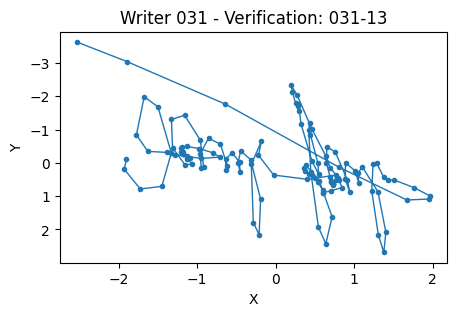

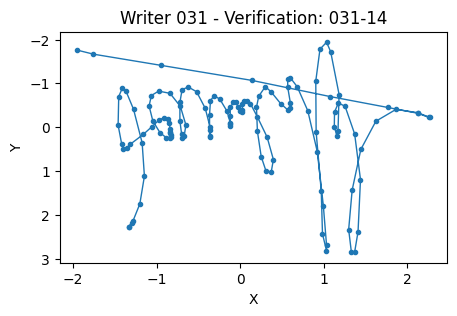

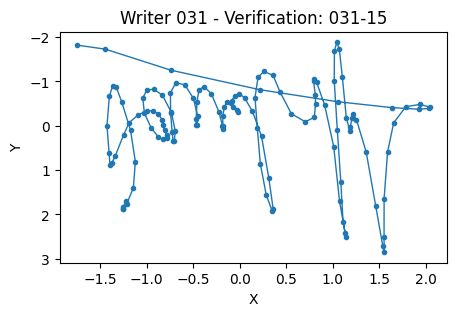

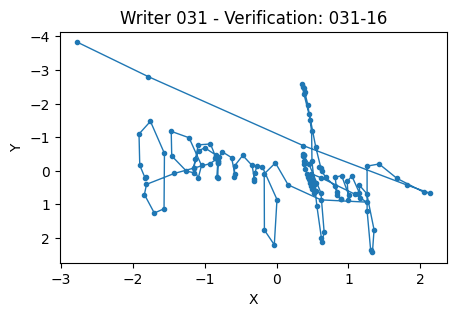

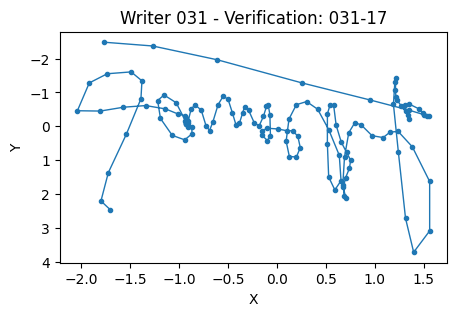

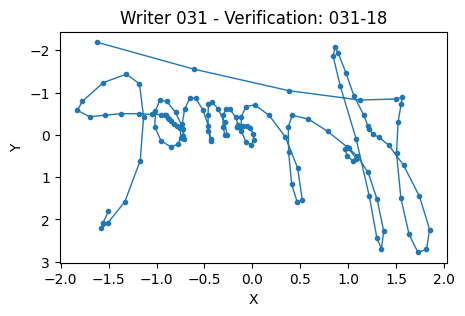

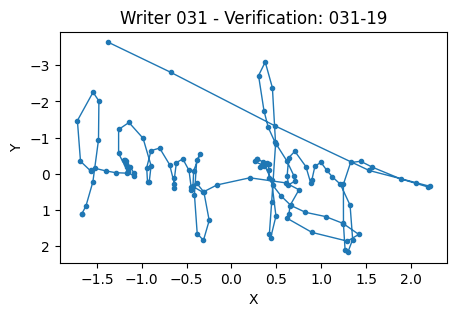

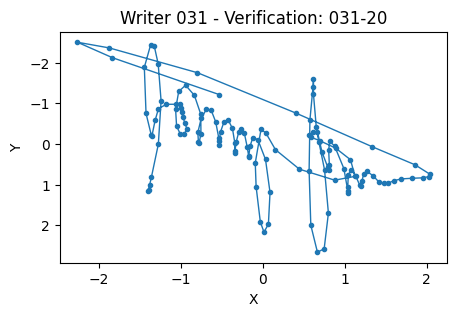

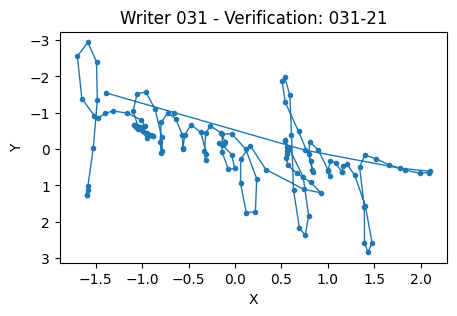

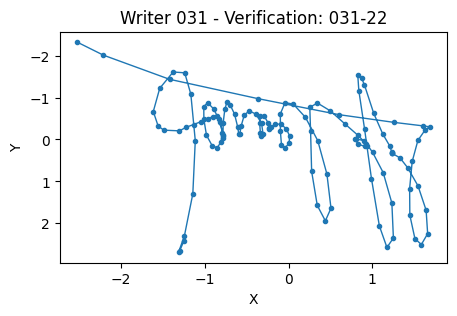

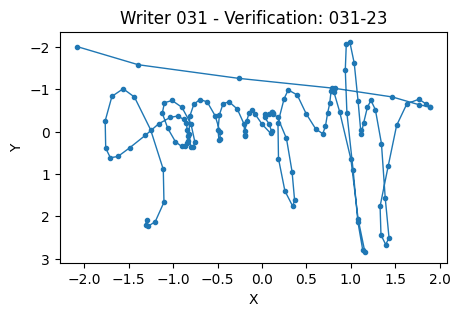

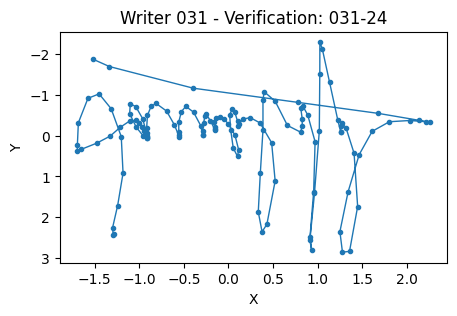

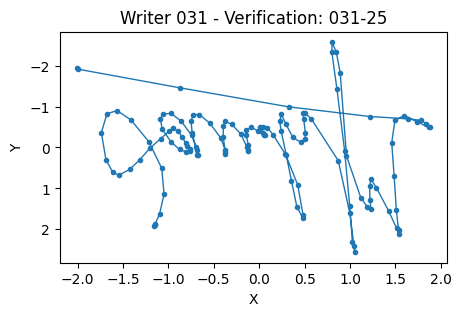

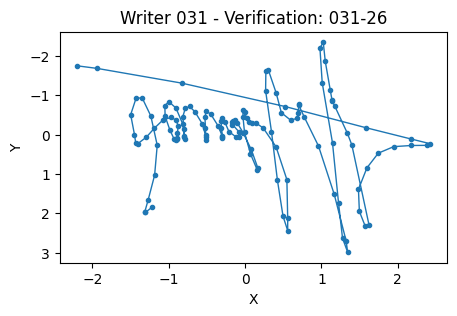

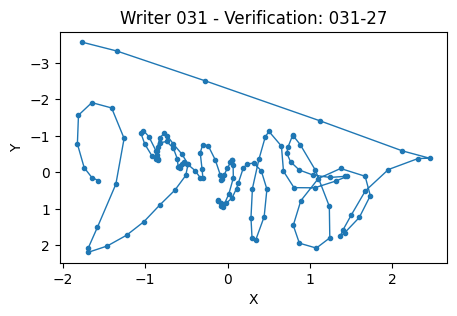

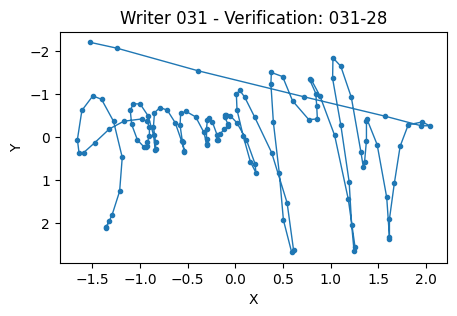

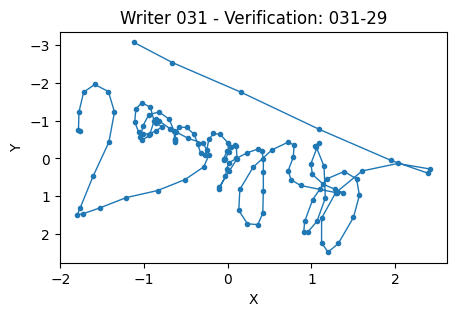

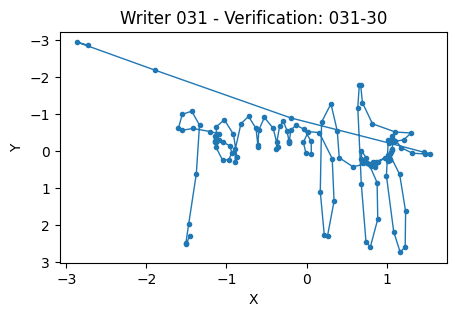

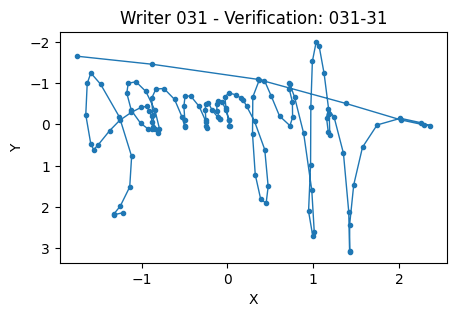

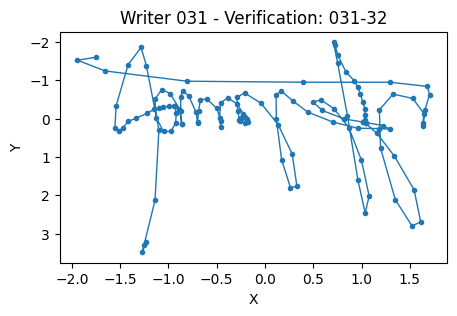

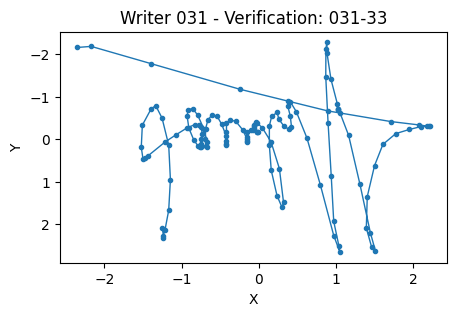

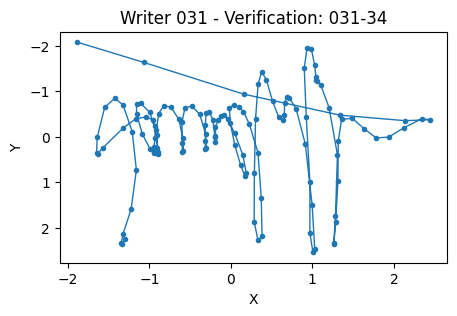

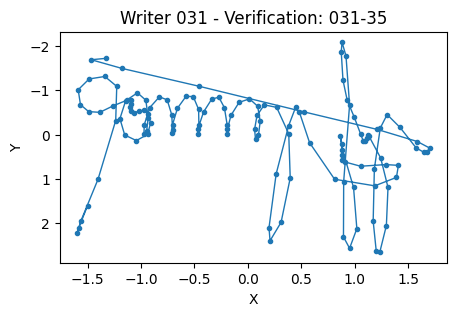

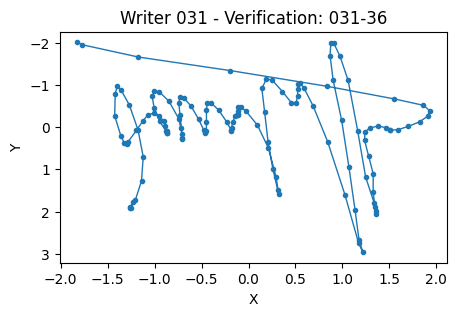

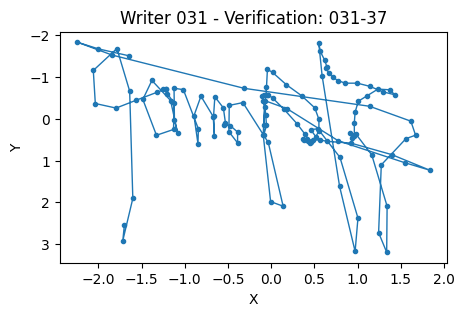

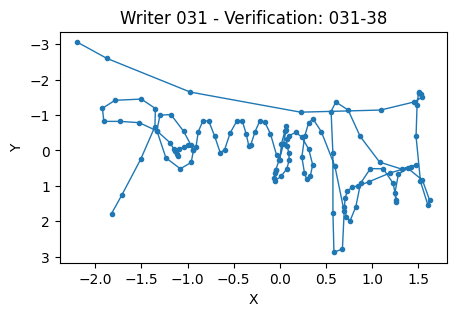

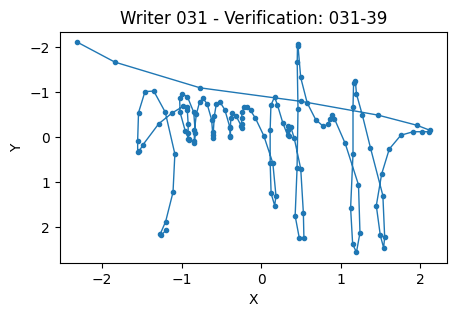

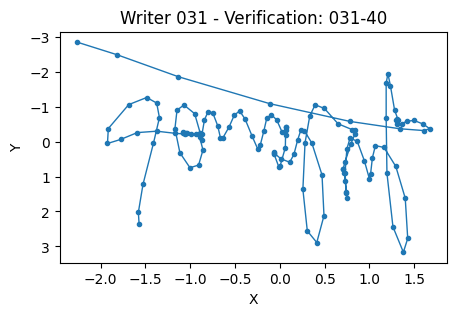

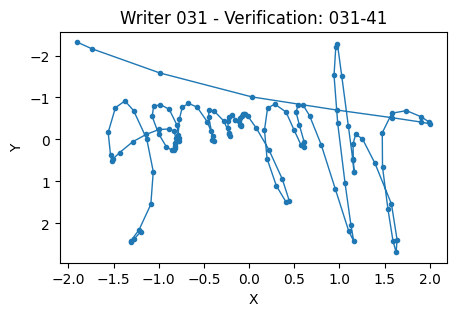

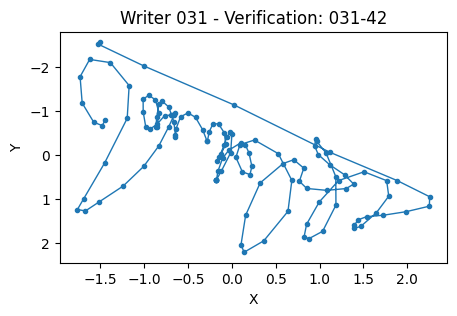

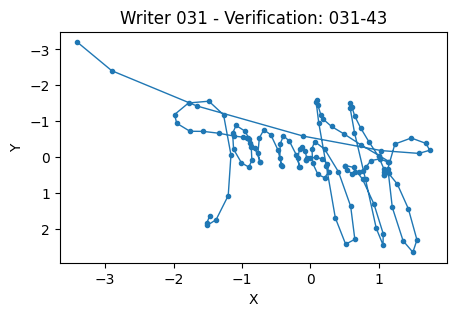

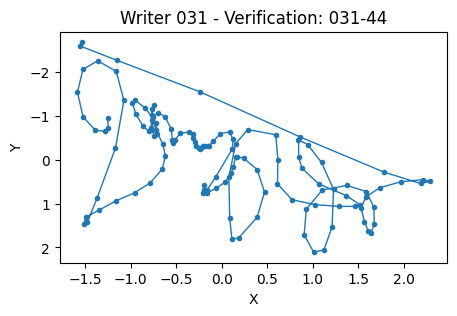

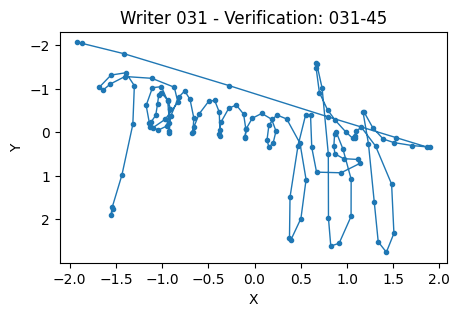

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


# Utility Functions

def list_signature_files(folder, pattern):
    """List all signature files in a folder matching a pattern."""
    return sorted(glob.glob(os.path.join(folder, pattern)))

def extract_xy_from_tsv(tsv_path):
    """Extract X, Y arrays from a signature TSV file (columns 1 and 2)."""
    df = pd.read_csv(tsv_path, sep="\t")
    x = df.iloc[:, 1].values
    y = df.iloc[:, 2].values
    return np.stack([x, y], axis=1)  # shape: (num_points, 2)

def plot_signature(sig_xy, title="Signature"):
    """Plot a 2D signature curve for visual inspection."""
    plt.figure(figsize=(5,3))
    plt.plot(sig_xy[:,0], sig_xy[:,1], marker='.', linewidth=1)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# Preprocessing 

def resample_signature(sig_xy, num_points=128):
    """Resample signature to a fixed number of points using interpolation."""
    t = np.linspace(0, 1, len(sig_xy))
    t_resampled = np.linspace(0, 1, num_points)
    x_interp = interp1d(t, sig_xy[:, 0], kind='linear')(t_resampled)
    y_interp = interp1d(t, sig_xy[:, 1], kind='linear')(t_resampled)
    return np.stack([x_interp, y_interp], axis=1)

def normalize_signature(sig_xy):
    """Normalize signature to zero mean and unit variance (per axis)."""
    mu = sig_xy.mean(axis=0)
    sigma = sig_xy.std(axis=0)
    sigma[sigma == 0] = 1  
    return (sig_xy - mu) / sigma


# Batch Loading & Organizing

def load_signatures(folder, writer_id, is_enrollment=False):
    """Load all signatures for a given writer (enrollment or verification)."""
    pattern = f"{writer_id}-g-*.tsv" if is_enrollment else f"{writer_id}-*.tsv"
    file_list = list_signature_files(folder, pattern)
    signatures = {}
    for fpath in file_list:
        sig_id = os.path.splitext(os.path.basename(fpath))[0]
        sig_xy = extract_xy_from_tsv(fpath)
        sig_xy = resample_signature(sig_xy, num_points=128)
        sig_xy = normalize_signature(sig_xy)
        signatures[sig_id] = sig_xy
    return signatures

# Organizing Data for All Writers


def get_all_writer_ids(enrollment_folder):
    """Return a sorted list of unique writer IDs from the enrollment folder."""
    files = list_signature_files(enrollment_folder, "*.tsv")
    writer_ids = sorted(set([os.path.basename(f)[:3] for f in files]))
    return writer_ids

enrollment_folder = "enrollment"
verification_folder = "verification"

# Get all writer IDs 
writer_ids = get_all_writer_ids(enrollment_folder)

# Organize all data
enrollment_data = {}
verification_data = {}

for writer_id in writer_ids:
    enrollment_data[writer_id] = load_signatures(enrollment_folder, writer_id, is_enrollment=True)
    verification_data[writer_id] = load_signatures(verification_folder, writer_id, is_enrollment=False)

writer_example = writer_ids[0]
for sig_id, sig_xy in enrollment_data[writer_example].items():
    plot_signature(sig_xy, f"Writer {writer_example} - Enrollment: {sig_id}")

for sig_id, sig_xy in verification_data[writer_example].items():
    plot_signature(sig_xy, f"Writer {writer_example} - Verification: {sig_id}")

